In [1]:
import pandas as pd
import numpy as np
from scipy.stats import stats
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
path = 'CA_edu_data/'

## Try reading in full CSV (need to fix CDS code?)

In [77]:
sb_df_all2 = pd.read_csv(path+'HS_testscores_meta.csv')

In [84]:
_cds = []
for cds in sb_df_all2['cds']:
    cds = str(cds)
    if len(cds)<14:
        cds = '0'*(14-len(cds))+cds
        _cds.append(cds)
    else:
        _cds.append(cds)
sb_df_all2['cds'] = _cds  
sb_df_all2 = sb_df_all2.set_index(sb_df_all2.cds)

In [85]:
_sb_df_all = sb_df_all
sb_df_all = sb_df_all2

In [86]:
assign_var = ['CharterYN','area1_perc_std_exceed','area3_perc_std_exceed', 'MetUCCSURate_RH','RegularHSGradRate_GF', 'ELRate_12',  'MetUCCSURate_TA']
assign_numeric = ['area1_perc_std_exceed','area3_perc_std_exceed', 'MetUCCSURate_RH','RegularHSGradRate_GF', 'ELRate_12',  'MetUCCSURate_TA']
assign_scaled = []
for col in assign_numeric:
    sb_df_all[col] = pd.to_numeric(sb_df_all[col])

assign_df =sb_df_all[assign_var].dropna()

In [87]:
# fix this to not be row-wise...
# this adds variables that are scaled to mean = 0 and unit standard deviation
for col in assign_numeric:
    avg = np.mean(assign_df[col])
    std = np.std(assign_df[col])
    _vec = []
    for ik in range(len(assign_df)):
        try:
            _vec.append((assign_df[col].iloc[ik]-avg)/std)
        except:
            _vec.append(np.nan)
    assign_scaled.append(col+'_ss')
    assign_df[col+'_ss'] = _vec #scaler.transform(assign_df[col])#
    #(assign_df[col]-np.mean(assign_df[col]))/assign_df[col].std
    #assign_numeric.append(col+_ss)
    


In [88]:
means = assign_df[['area1_perc_std_exceed','area3_perc_std_exceed']].mean(axis=0)
stds = assign_df[['area1_perc_std_exceed','area3_perc_std_exceed']].std(axis=0)
assign_df['areas13_perc_std_exceed_ss'] = ((assign_df[['area1_perc_std_exceed','area3_perc_std_exceed']] - means) / stds).mean(axis=1)
assign_scaled.append('areas13_perc_std_exceed_ss')


In [89]:
assign_df['ELRate_12_sqrt_ss']= np.sqrt(assign_df['ELRate_12'].dropna())
assign_df['ELRate_12_sqrt_ss'] = (assign_df['ELRate_12_sqrt_ss']-assign_df['ELRate_12_sqrt_ss'].mean(axis=0))/assign_df['ELRate_12_sqrt_ss'].std(axis=0)


assign_scaled.append('ELRate_12_sqrt_ss')

In [ ]:
means = assign_df[['RegularHSGradRate_RB','RegularHSGradRate_RA']].mean(axis=0)
stds = assign_df[['RegularHSGradRate_RB','RegularHSGradRate_RA']].std(axis=0)
assign_df['RegularHSGradRate_RBRA_ss'] = ((assign_df[['RegularHSGradRate_RB','RegularHSGradRate_RA']] - means) / stds).mean(axis=1)
assign_scaled.append('RegularHSGradRate_RBRA_ss')


In [90]:
assign_df['RegularHSGradRate_GF_sqrt_ss']= np.sqrt(assign_df['RegularHSGradRate_GF'].dropna())
assign_df['RegularHSGradRate_GF_sqrt_ss'] = (assign_df['RegularHSGradRate_GF_sqrt_ss']-assign_df['RegularHSGradRate_GF_sqrt_ss'].mean(axis=0))/assign_df['RegularHSGradRate_GF_sqrt_ss'].std(axis=0)
assign_scaled.append('RegularHSGradRate_GF_sqrt_ss')

In [74]:
from sklearn.preprocessing import PolynomialFeatures
pf = PolynomialFeatures(degree=2, interaction_only=False,  
                        include_bias=False)
res = pf.fit_transform(assign_df[['ELRate_12_ss', 'MetUCCSURate_RH_ss']])

intr_features = pd.DataFrame(res, columns=['EL12', 'elig_RH',  
                                           'ELRate_12_2', 
                                           'ELRate_12_x_MetUCCSURate_RH',  
                                           'MetUCCSURate_RH_2'])

assign_df['ELRate_12_2'] = intr_features['ELRate_12_2']
assign_df['ELRate_12_x_MetUCCSURate_RH'] = intr_features['ELRate_12_x_MetUCCSURate_RH']
assign_df['MetUCCSURate_RH_2'] = intr_features['MetUCCSURate_RH_2']

assign_scaled.append('ELRate_12_2')
assign_scaled.append('ELRate_12_x_MetUCCSURate_RH')
assign_scaled.append('MetUCCSURate_RH_2')

In [75]:
intr_features.head()

,EL12,elig_RH,ELRate_12_2,ELRate_12_x_MetUCCSURate_RH,MetUCCSURate_RH_2
0,-1.054329,2.724640,1.111611,-2.872668,7.423663
1,-1.054329,2.724640,1.111611,-2.872668,7.423663
2,-1.054329,0.044341,1.111611,-0.046750,0.001966
3,-1.054329,0.044341,1.111611,-0.046750,0.001966
4,-1.054329,0.018960,1.111611,-0.019990,0.000359


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


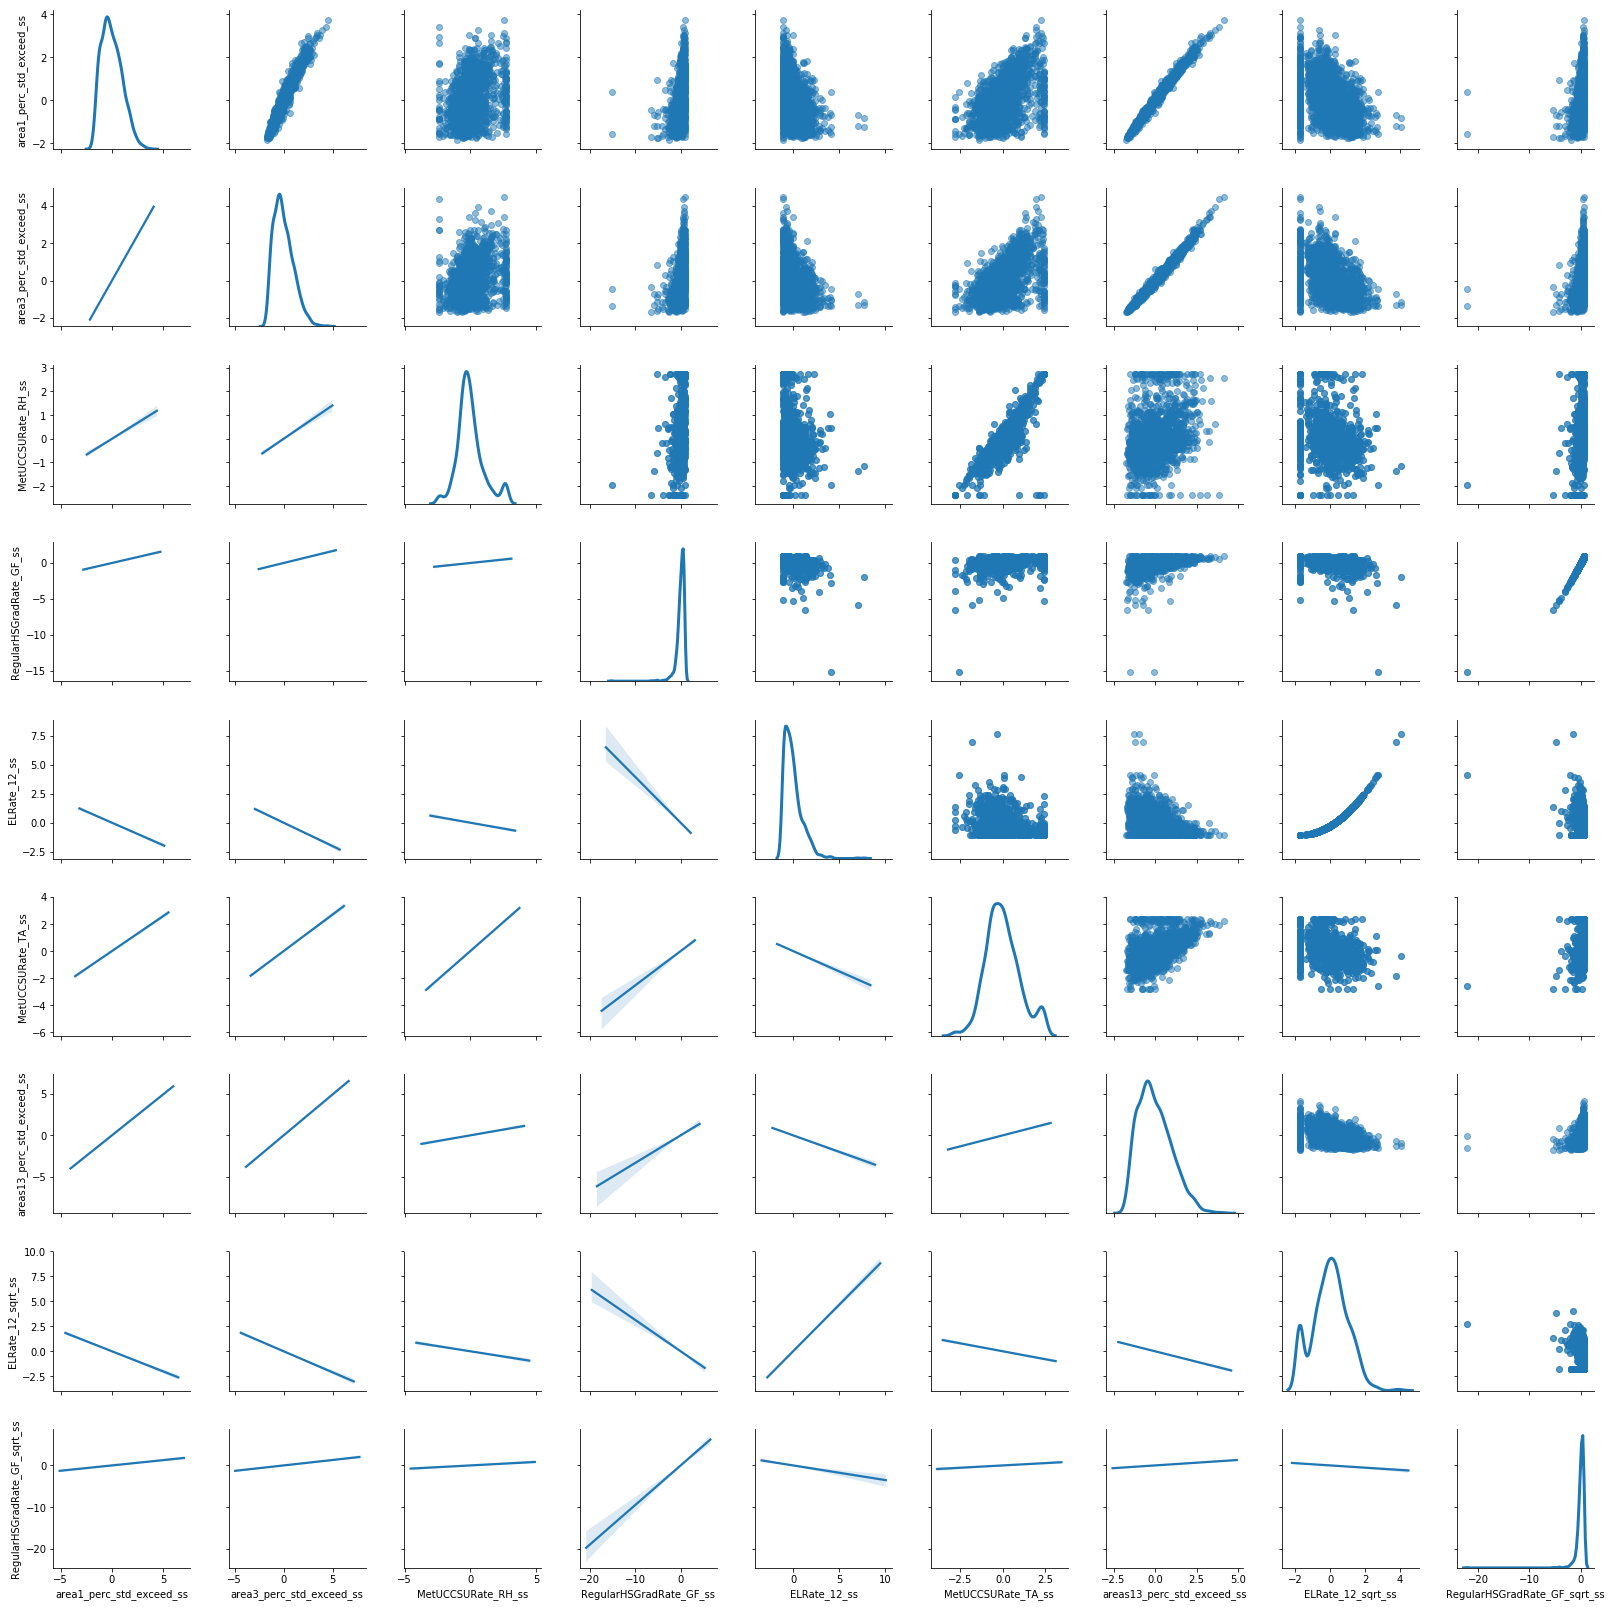

In [91]:
g = sns.PairGrid(assign_df[assign_scaled].dropna(), diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)


## corrmat = assign_df[assign_scaled].dropna().corr()

fig, ax = plt.subplots(1,1, figsize = (12,9))
sns.heatmap(corrmat, vmax = 1, square = True)

In [52]:
testing = ['perc_std_exceed',
       'perc_std_met_exceed', 'area1_perc_std_exceed', 'area2_perc_std_exceed', 'area3_perc_std_exceed',
         'RegularHSGradRate_GF', 'RegularHSGradRate_RB',
         'MetUCCSURate_RA', 'MetUCCSURate_RB',  'ELRate_12',
       'MetUCCSURate_TA']
# 'perc_std_met','RegularHSGradRate_RA',
# 'RegularHSGradRate_GF', 'RegularHSGradRate_GM','RegularHSGradRate_GF', 'RegularHSGradRate_GM',
# 'RegularHSGradRate_RH', 'MetUCCSURate_RH', 'cds','mean_scale_score', 'area4_perc_std_exceed',
# 'area1_perc_std_near','area3_perc_std_near','area2_perc_std_near',  'area4_perc_std_near',


In [166]:
scaler = preprocessing.StandardScaler().fit(sb_df_all[testing])

sb_df_all_scaled = sb_df_all[testing]
sb_df_all_scaled[testing] = scaler.fit_transform(sb_df_all_scaled)# scaler.transform(HS_sub[HS_numeric].dropna())

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
 

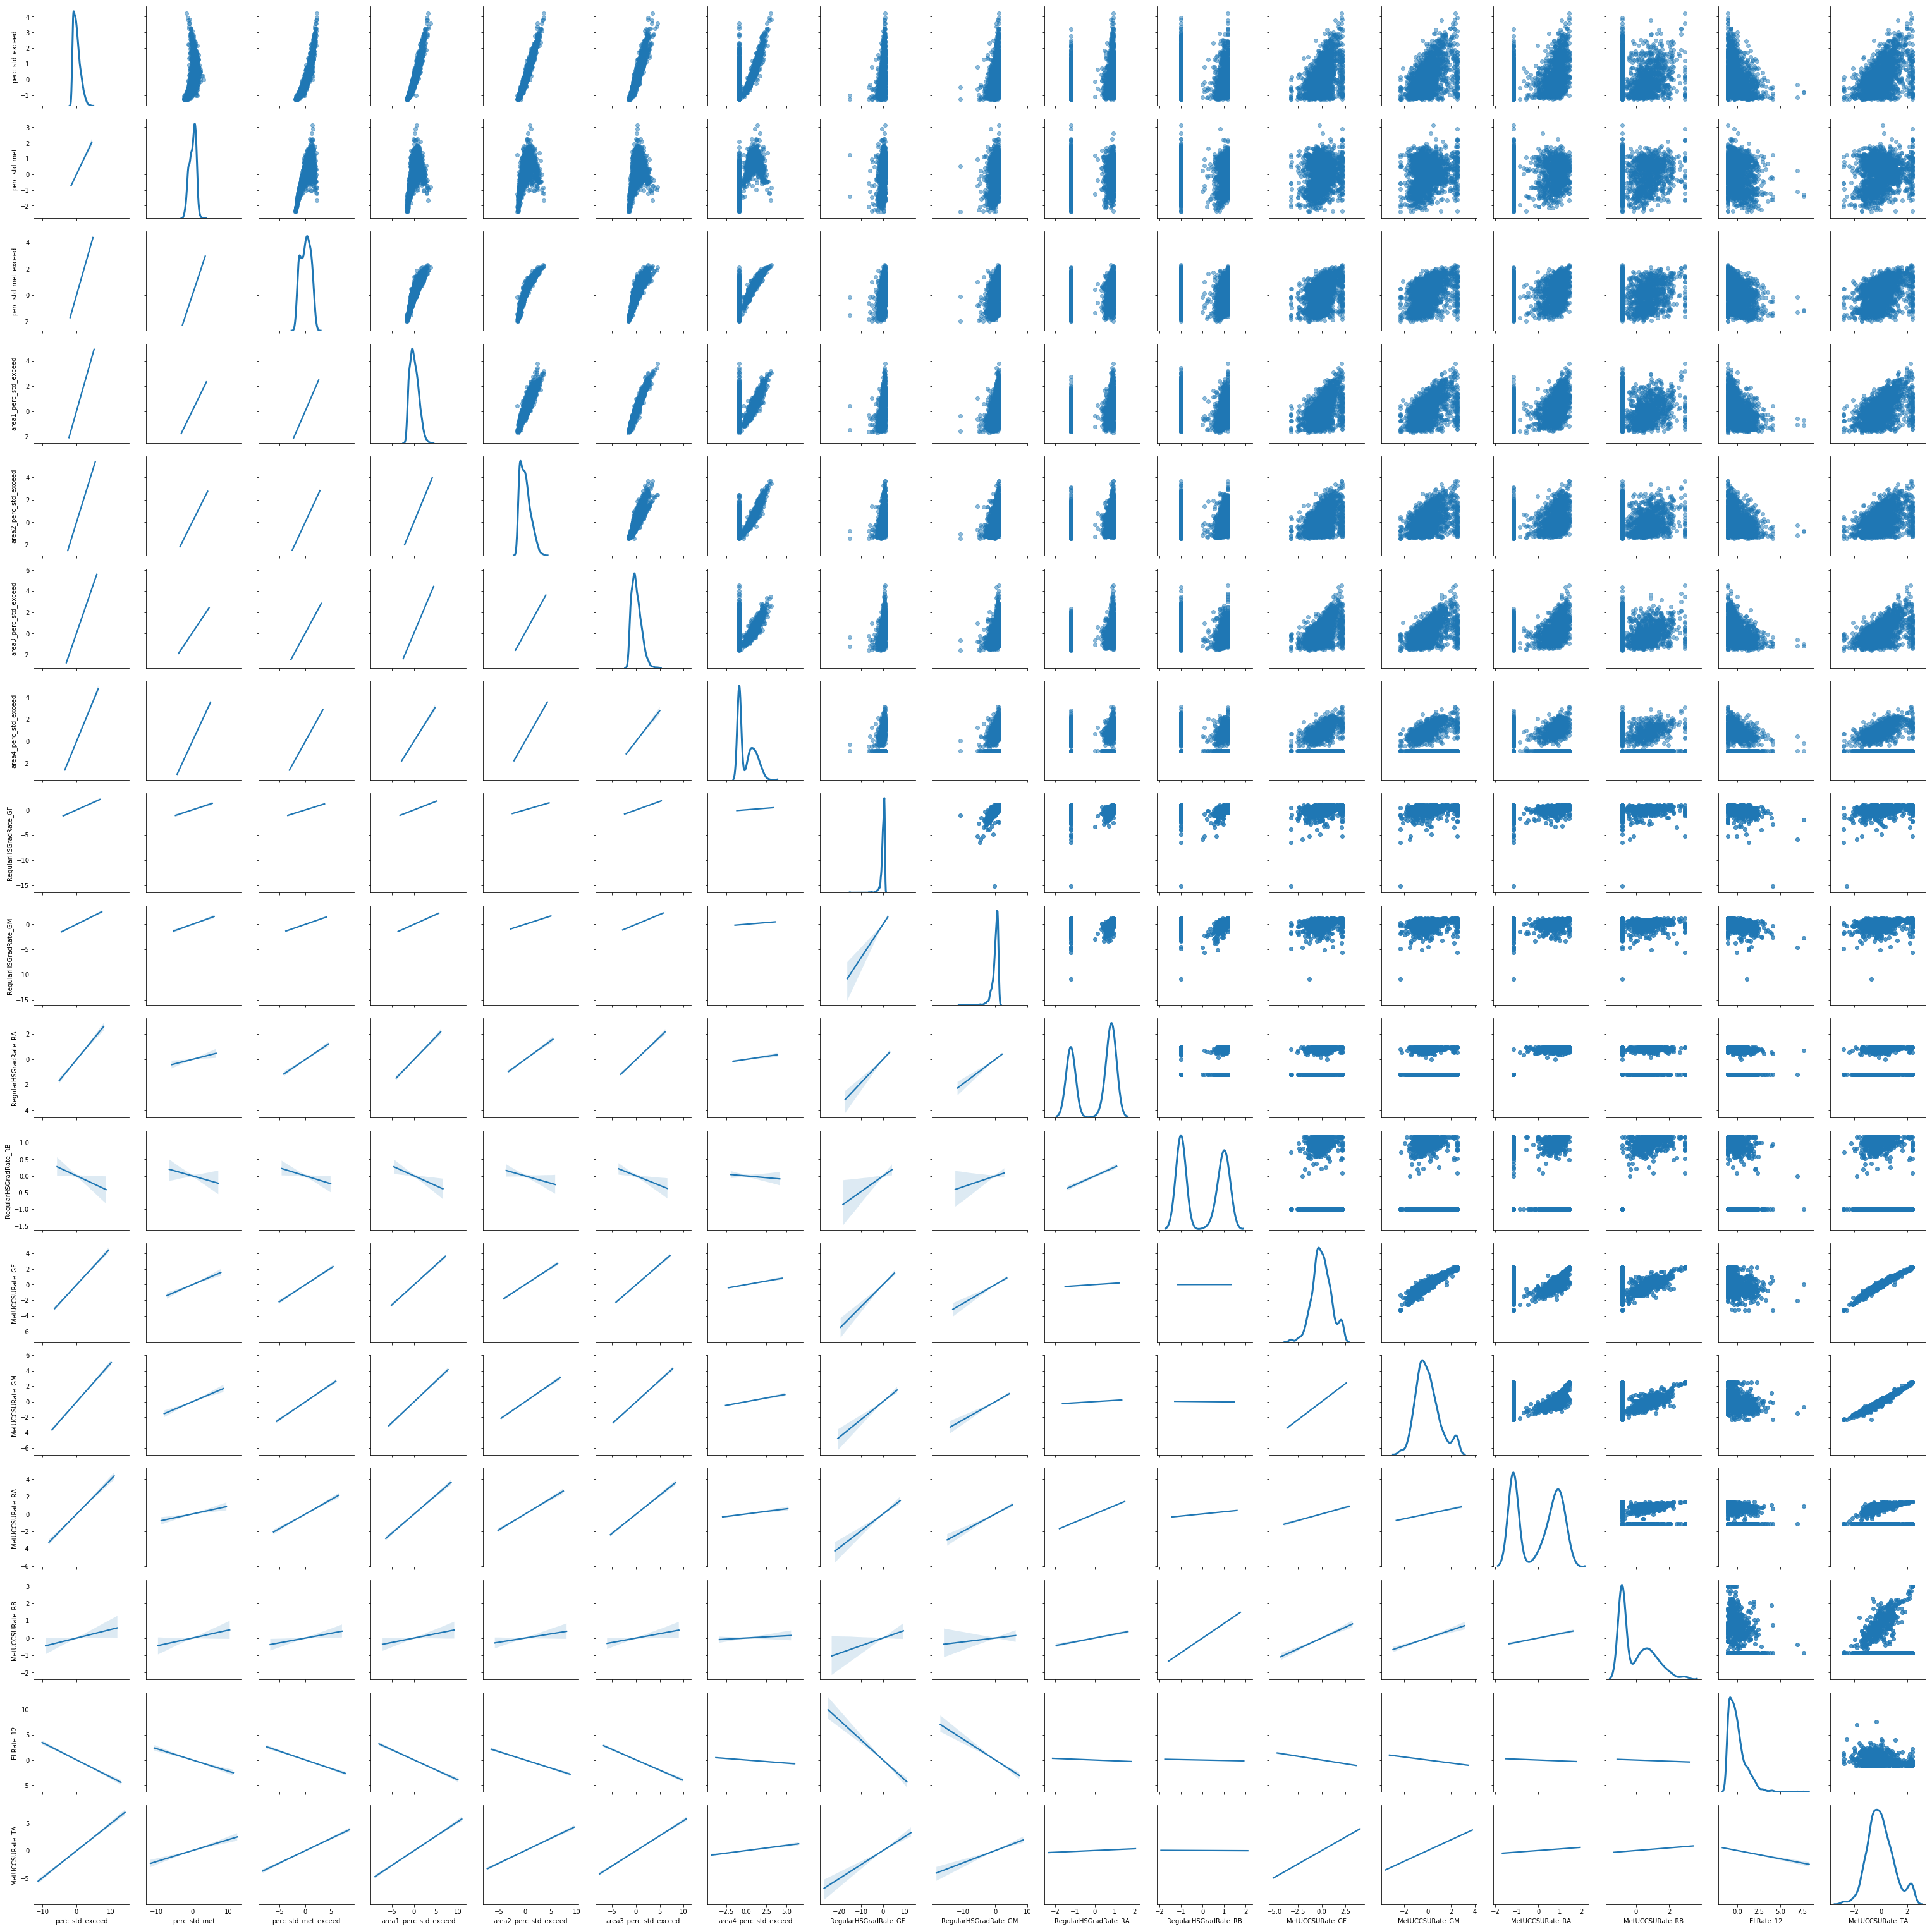

In [167]:
g = sns.PairGrid(sb_df_all_scaled[testing].dropna(), diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)


In [168]:
from sklearn import preprocessing
from sklearn.preprocessing import PowerTransformer
# scaler = preprocessing.StandardScaler().fit(HS_sub[HS_numeric])
pt = preprocessing.PowerTransformer(method='yeo-johnson', standardize=False)

sb_df_all_scaled2 = sb_df_all[testing]
sb_df_all_scaled2[testing] = pt.fit_transform(sb_df_all_scaled2)# scaler.transform(HS_sub[HS_numeric].dropna())


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2544: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.loc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:2514: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_array(key, v

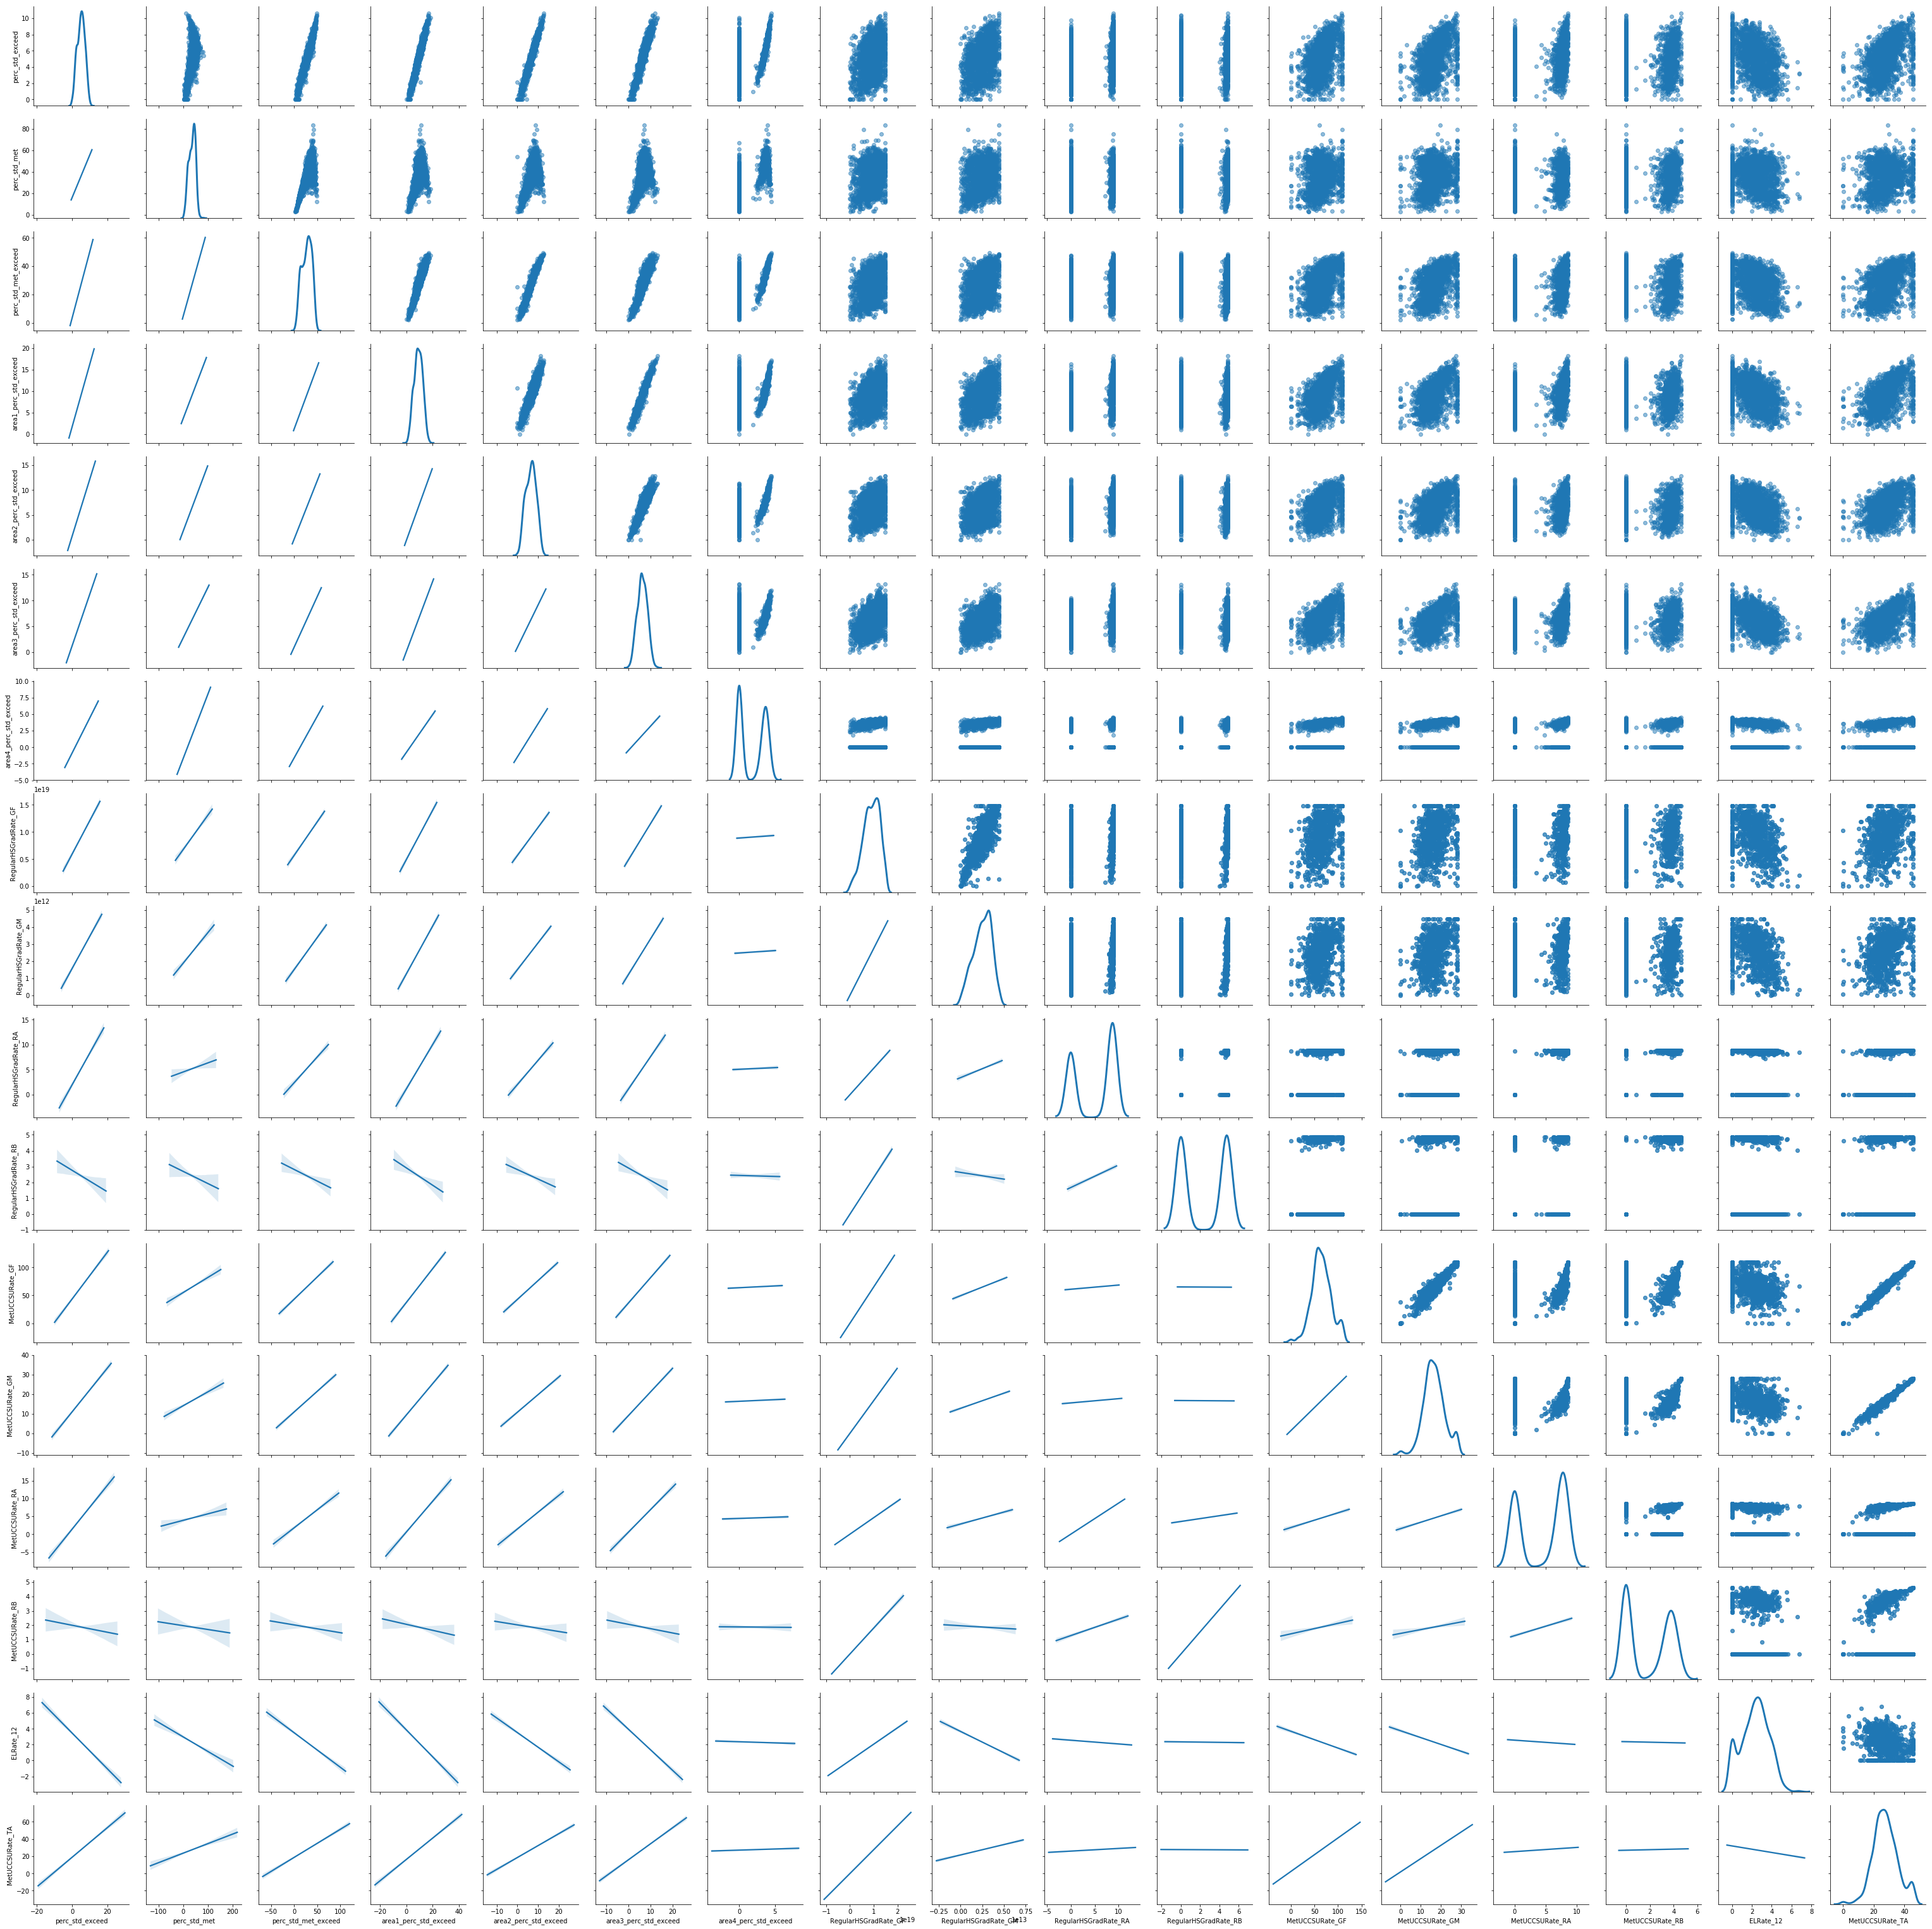

In [169]:
g = sns.PairGrid(sb_df_all_scaled2[testing].dropna(), diag_sharey = False)
g.map_upper(plt.scatter, alpha = .5)
g.map_lower(sns.regplot, scatter_kws= dict(alpha = 0))
g.map_diag(sns.kdeplot, lw = 3)


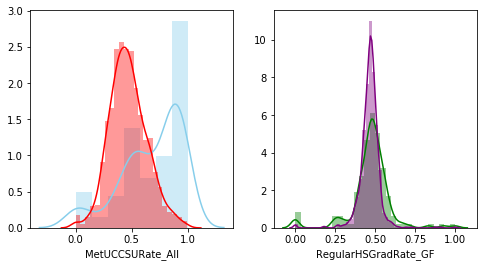

In [471]:
# print(len(HS_sub['MetUCCSURate_All'].dropna()), len(HS_sub['MetUCCSURate_All']))
# sns.distplot(HS_sub[HS_sub.CharterYN == 1]['MetUCCSURate_All'].dropna(), color= 'skyblue')
# sns.distplot(HS_sub[HS_sub.CharterYN == 0]['MetUCCSURate_All'].dropna(), color= 'red')

fig, ax = plt.subplots(1, 2, figsize = (8, 4))
# print(len(HS_sub['MetUCCSURate_All'].dropna()), len(HS_sub['MetUCCSURate_All']))
sns.distplot(HS_sub[HS_sub.CharterYN == 1]['MetUCCSURate_All'].dropna(), color= 'skyblue', ax = ax[0])
sns.distplot(HS_sub[HS_sub.CharterYN == 0]['MetUCCSURate_All'].dropna(), color= 'red', ax = ax[0])

sns.distplot(HS_sub[HS_sub.CharterYN == 1]['RegularHSGradRate_GF'].dropna(), color= 'green', ax = ax[1])
sns.distplot(HS_sub[HS_sub.CharterYN == 0]['RegularHSGradRate_GF'].dropna(), color= 'purple', ax = ax[1])
# There is no number that demonstrates that school district size has an appreciable effect
# on UC/CSU eligibility